In [73]:
%pylab inline
from dolfin import *
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [103]:
#Rayon rho
r=0.35

#Nx=Ny=N
N=50

#Paramètres mu             #mu0 entre 0.1 et 10
mu = np.array([10,-1])     #mu1 entre  -1 et 1


def Solver(mu0,mu1,N=50,r=0.2):
    mu = np.array([mu0,mu1])
    # Create classes for defining parts of the boundaries and the interior
    # of the domain
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], 0.0)

    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], 1.0)

    class Bottom(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], 0.0)

    class Top(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], 1.0)

    class Gamma0(SubDomain):
        def inside(self, x, on_boundary):
            return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

    # Initialize sub-domain instances
    left   = Left()
    top    = Top()
    right  = Right()
    bottom = Bottom()
    gamma  = Gamma0()

    # Define mesh
    mesh = UnitSquareMesh(N,N)

    # Initialize mesh function for interior domains
    domains = MeshFunction("size_t", mesh, mesh.topology().dim())
    domains.set_all(0)         #domains 0 = all space
    gamma.mark(domains, 1)     #domains 1 = all gamma0

    # Initialize mesh function for boundary domains
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
    boundaries.set_all(0)      #boundaries 0 = all boundaries
    left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
    top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
    right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
    bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

    # Define input data
    a1 = Constant(mu[0])  
    a2 = Constant(mu[1])

    # Define function space and basis functions
    V = FunctionSpace(mesh, "CG", 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Define Dirichlet boundary conditions at top and bottom boundaries
    bcs = [DirichletBC(V, 0.0, boundaries, 2)]

    # Define new measures associated with the interior domains and
    # exterior boundaries
    dx = Measure('dx', domain=mesh, subdomain_data=domains)
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    # Separate left and right hand sides of equation
    a = inner(grad(u),grad(v))*dx(0) + inner(a1*grad(u),grad(v))*dx(1)
    L = a2*v*ds(4)

    #A = assemble(a)
    b = assemble(L)

    # Solve problem
    u = Function(V)
    solve(a == L,u, bcs)
    #solve(A,u,b,bcs)
    
    A = np.outer(b.get_local(), u.vector().get_local().T)
    print("A :",np.shape(A))
    print("b :",np.shape(b.get_local()))
    print("u :",np.shape(u.vector().get_local()))
    urep = npl.solve(A,b.get_local())
    
    return u

In [104]:
u = Solver(2,0.9)

# Plot solution
plt.figure()
c = plot(u, title="Heat")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(c)
plt.show()

A : (2601, 2601)
b : (2601,)
u : (2601,)


LinAlgError: Singular matrix

In [114]:
b = np.array([58,160])
x = np.array([22,36])
A = np.array([[1,1],[4,2]])
             
print(A)
print(npl.solve(A,b))
print()

[[1 1]
 [4 2]]
[22. 36.]
[[1276 3520]
 [2088 5760]]


# Passer de Function (Fenics) à nd.array (et inversement)

Type de u :  <class 'dolfin.function.function.Function'>


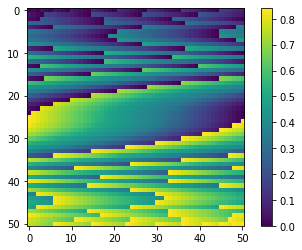

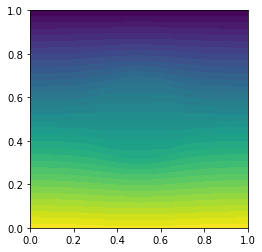

In [33]:
# On a u qui est de type Function
print("Type de u : ",type(u))

# On passe u en vecteur Numpy, uar
uar = u.vector().get_local()

# On peut reshape uar pour avoir une matrice mais ça fait un peu n'imp
uarrs = uar.reshape(51,51,order='A')
plt.figure()
plt.imshow(uarrs)
plt.colorbar()
plt.show()

# On prend u = Function(V) (défini dans la fonction Solver ici) et on passe en Function
u.vector().set_local(uarrs.reshape(2601))
plt.figure()
plot(u)
plt.show()

Traceback (most recent call last):
  File "/home/treillou/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/treillou/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/home/treillou/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/matplotlib/animation.py", line 1525, in _init_draw
    artist.set_visible(False)
AttributeError: 'TriContourSet' object has no attribute 'set_visible'


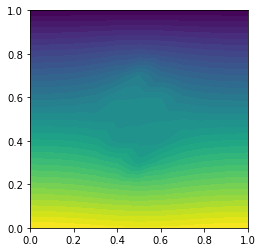

In [66]:
import matplotlib.animation as animation
mu1 = np.linspace(-1,1,10)
mu0 = np.linspace(0.1,10,10)
U = []
n = 0
fig = plt.figure()
ims = []
for i in range(10):
    for j in range(10):
            im=plot(Solver(mu0[i],mu1[j],N=10),animated=True)
            ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

In [ ]:
def greedy_algorithm(tol, MUs, A_delta, f_delta, n=1):
    # On prend un mu (au hasard) pour initialiser l'algorithme
    mu_1 = MUs[0]
    np.delete(MUs, 0)
    u_delta_mu_1 = npl.solve(A_delta(mu_1), f_delta(mu_1))
    
    # On calcule tous les u_delta pour éviter de le refair dans la boucle par la suite
    U_DELTA = np.array([npl.solve(A_delta(mu), f_delta(mu)) for mu in MUs])
    
    # B est la matrice de changement de base de A_delta à A_rb
    B = np.copy(u_delta_mu_1)
    
    err = 1e10
    
    while err > tol and MUs.shape[0] > 0:
        
        eta = np.zeros(MUs.shape[0])
        
        for idx_mu, mu in enumerate(MUs):
            A_delta_mu = A_delta(mu)
            f_delta_mu = f_delta(mu)
        
            u_delta_mu = U_DELTA[idx_mu]
            
            # A_rb_mu @ u_rb_mu = f_rb_mu
            # A_rb_mu = B.T @ A_delta_mu @ B
            u_rb_mu = npl.solve(B.T @ A_delta_mu @ B, B.T @ f_delta_mu)
            
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[idx_mu] = npl.norm(u_delta_mu - u_rb_mu, ord=2)
        
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        
        B = np.vstack((B, U_DELTA[idx_worst_mu]))
        
        np.delete(MUs, idx_worst_mu)
        np.delete(U_DELTA[idx_worst_mu])
        
        err = eta[idx_worst_mu]
        
    return B